In [7]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
#from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
#from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.wait import WebDriverWait

import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import time
from datetime import datetime
from time import sleep
import re

In [8]:
def get_tweet_data(card):
    #Extracts tweet from the element
    username = card.find_element_by_xpath('.//span').text
    
    
    try:
        handle = card.find_element_by_xpath('.//span[contains(text(), "@")]').text
    except NoSuchElementException:
        return
    
    try:
        postdate = card.find_element_by_xpath('.//time').get_attribute('datetime')
    except NoSuchElementException:
        return
    
    comment = card.find_element_by_xpath('.//div[2]/div[2]/div[1]').text
    responding = card.find_element_by_xpath('.//div[2]/div[2]/div[2]').text
    text = comment + ' ' + responding
    reply_cnt = card.find_element_by_xpath('.//div[@data-testid="reply"]').text
    retweet_cnt = card.find_element_by_xpath('.//div[@data-testid="retweet"]').text
    like_cnt = card.find_element_by_xpath('.//div[@data-testid="like"]').text
    
    # get a string of all emojis contained in the tweet
    """Emojis are stored as images... so I convert the filename, which is stored as unicode, into 
    the emoji character."""
    emoji_tags = card.find_elements_by_xpath('.//img[contains(@src, "emoji")]')
    emoji_list = []
    for tag in emoji_tags:
        filename = tag.get_attribute('src')
        try:
            emoji = chr(int(re.search(r'svg\/([a-z0-9]+)\.svg', filename).group(1), base=16))
        except AttributeError:
            continue
        if emoji:
            emoji_list.append(emoji)
    emojis = ' '.join(emoji_list)
    
    tweet = (username, handle, postdate, text, emojis, reply_cnt, retweet_cnt, like_cnt)
    return tweet

In [11]:
#Set path of search engine & initiate the driver
PATH = "/Applications/chromedriver"
driver = webdriver.Chrome(PATH)

#Sets the page for scrape: twitter & waits 10 seconds to load page
driver.get("https://twitter.com/explore")
wait = WebDriverWait(driver,10)
sleep(10)

#Searches for Twitter search bar using xpath
search_input = driver.find_element_by_xpath('//input[@aria-label="Search query"]')

#User inputs
#ßsearch_input.send_keys('latinx lang:es geocode:54.597271,-5.930110,20km')
search_input.send_keys('latinx lang:es')

search_input.send_keys(Keys.RETURN)
sleep(10)

#Clicks on the tab 'latest'
driver.find_element_by_link_text('Latest').click()

#Collects all tweets in page
data = []
tweet_ids = set()
last_position = driver.execute_script("return window.pageYOffset;")
scrolling = True

while scrolling:
    page_cards = driver.find_elements_by_xpath('//div[@data-testid="tweet"]')
    for card in page_cards[-15:]:
        tweet = get_tweet_data(card)
        if tweet:
            tweet_id = ''.join(tweet)
            if tweet_id not in tweet_ids:
                tweet_ids.add(tweet_id)
                data.append(tweet)
            
    scroll_attempt = 0
    while True:
        # check scroll position
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        sleep(2)
        curr_position = driver.execute_script("return window.pageYOffset;")
        if last_position == curr_position:
            scroll_attempt += 1
            
            # end of scroll region
            if scroll_attempt >= 3:
                scrolling = False
                break
            else:
                sleep(2) # attempt another scroll
        else:
            last_position = curr_position
            break
    
# close the web driver
driver.close()

In [12]:
#Prints out the amount of tweets collected
print("Tweets extracted: " + str(len(data)))

Tweets extracted: 444


In [13]:
#Frist cycle cleaning: raw data from scrapped tweets to DataFrame
def cleanTweets1():
    tweetList = []
    for i in data:
        tweetList.append(i)
    df = pd.DataFrame(tweetList)
    df = df.rename(columns={df.columns[0]: 'username', df.columns[1]: 'handle', df.columns[2]: 'date', df.columns[3]: 'message', df.columns[4]: 'emojis', df.columns[5]: 'reply_cnt', df.columns[6]: 'retweet_cnt', df.columns[7]: 'like_cnt'})
    return df

#Second cycle cleaning: remove noise from the tweets stored DataFrame
def cleanTweets2(text):
    text = re.sub(r'#', ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub('(?:\s)@[^, ]*', '', text)

    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'Replying to[\s]+', '', text)
    return text

#Implementing the data cleaners
df = cleanTweets1()
df['message'] = df['message'].apply(cleanTweets2)

In [14]:
#Get subjectivity & polarity using TextBlob library
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Subjectivity and polarity functions implemented
df['subjectivity'] = df['message'].apply(getSubjectivity)
df['polarity'] = df['message'].apply(getPolarity)

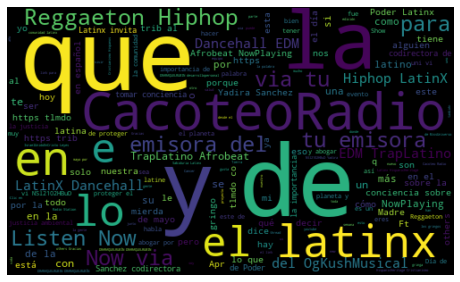

In [15]:
#A visual representation #1: strength of words scrapped using WordCloud library
everyWord = ' '.join([tweets for tweets in df['message']])
wordCloud = WordCloud(width= 500, height = 300, random_state = 21, max_font_size = 110).generate(everyWord)

sentWordCloud = plt.figure(figsize=(8,6))
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [16]:
#Get results and store them in the df column as 'positive', 'neutral', 'negative'
def getAnalysis(score):
    if score < 0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

df['analysis'] = df['polarity'].apply(getAnalysis)

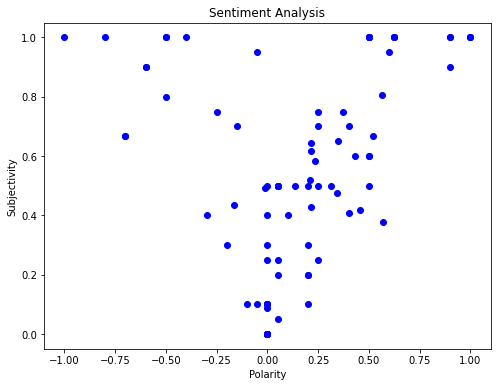

In [17]:
#A visual representation #2: observe subjectivity and polarity in a scatter plot
sentPolFig = plt.figure(figsize=(8,6))
for i in range(0, df.shape[0]):
    plt.scatter(df['polarity'][i], df['subjectivity'][i], color='Blue')

plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

In [20]:
#Making descriptive stats of positive, negative and neutral tweets

postweets = df[df.analysis == 'positive']
postweets = postweets['message']

neutweets = df[df.analysis == 'neutral']
neutweets = neutweets['message']

negtweets = df[df.analysis == 'negative']
negtweets = negtweets['message']

postwtperc = str(round((postweets.shape[0] / df.shape[0]) *100, 1)) + "% of people made positive comments about Bitcoin"
neutwtperc = str(round((neutweets.shape[0] / df.shape[0]) *100, 1)) + "% of people made neutral comments about Bitcoin"
negtwtperc = str(round((negtweets.shape[0] / df.shape[0]) *100, 1)) + "% of people made negative comments about Bitcoin"

11.5% of people made positive comments about Bitcoin
84.2% of people made neutral comments about Bitcoin
4.3% of people made negative comments about Bitcoin



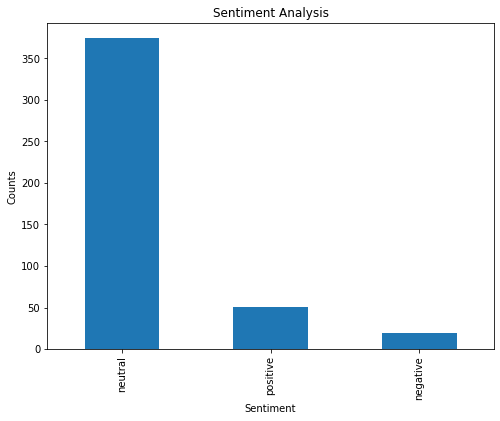

In [19]:
#A visual representation #3: bar plot of positive, negative and neutral tweets and its percentages
print(postwtperc)
print(neutwtperc)
print(negtwtperc)
print()

sentPerc = plt.figure(figsize=(8,6))

plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df.analysis.value_counts().plot(kind='bar')

plt.show()

In [427]:
#Exports the df to CSV and graphs to PDF
time = str(now.strftime("%d-%m-%Y %H:%M:%S"))
df.to_csv('twitter-sentiment-analysis' + ' - ' + time +'.csv')

sentPolFig.savefig('sentiment-polarity.pdf')
sentPerc.savefig('sentiment-percentage.pdf')
sentWordCloud.savefig('sentiment-wordcloud.pdf')